### evaluate
  
evaluate projects by  
>different concentrations, same reagence (given here for NO2) or  
different reagences  

>build a model of <b>OLS</b> to train, test and predict unknown concentrations  

>give notes the evaluation chain

In [1]:
import os, datetime, socket
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fprojects = [
  ("Nitrit NO2","2023-06-13"),
  ("Nitrit NO2","2023-06-14")
]

metric = "euclidean"
space = "lab"

print(f"author  {socket.gethostname():>28}")
print(f"version {str(datetime.datetime.now()):>28}")


author                           NOB
version   2023-08-20 04:22:41.198527


### load projects

load comparable data results from pickle files, given by 02.sample  
concat the pickles to one data frame

In [2]:
data = None

for fproject in fprojects:

    fname = os.path.join(os.getcwd(),"data",fproject[1],fproject[0],"result",f"{space}.{metric}.values.pickle")
    
    frame = pd.read_pickle(fname)
    frame['project'] = "_".join(fproject)
    frame['date'] = fproject[1]
    if data is None: data = frame
    else: data = pd.concat([data, frame])
        
print(data.to_markdown())

|    | project               |   index |   label | metric    | space   |        l |        a |        b | date       |
|---:|:----------------------|--------:|--------:|:----------|:--------|---------:|---------:|---------:|:-----------|
|  0 | Nitrit NO2_2023-06-13 |       0 |   0.01  | euclidean | lab     | 0.430652 | 0.517578 | 0.562847 | 2023-06-13 |
|  1 | Nitrit NO2_2023-06-13 |       0 |   0.034 | euclidean | lab     | 0.413787 | 0.529351 | 0.56121  | 2023-06-13 |
|  2 | Nitrit NO2_2023-06-13 |       0 |   0.061 | euclidean | lab     | 0.378746 | 0.541572 | 0.559957 | 2023-06-13 |
|  3 | Nitrit NO2_2023-06-13 |       0 |   0.095 | euclidean | lab     | 0.361228 | 0.55648  | 0.558924 | 2023-06-13 |
|  4 | Nitrit NO2_2023-06-13 |       0 |   0.121 | euclidean | lab     | 0.345198 | 0.566267 | 0.559216 | 2023-06-13 |
|  5 | Nitrit NO2_2023-06-13 |       0 |   0.155 | euclidean | lab     | 0.326846 | 0.577057 | 0.558882 | 2023-06-13 |
|  6 | Nitrit NO2_2023-06-13 |       0 |   0.181

### train/test set build

to build a regression model  
>select a training data set  
select a test data set  
  
and locate it in the data 

In [3]:
train_set = 'Nitrit NO2_2023-06-13'
test_set = 'Nitrit NO2_2023-06-14'

data['train'] = 0
data.loc[data['project']==train_set,'train'] = 1

### store

store the test and training data set for further investigations to a csv file  

In [4]:
fprefix = ".".join(["_".join(fproject) for fproject in fprojects])
fname = os.path.join(os.getcwd(),"eval","%s.%s.%s.csv"%(fprefix,space,metric))

data.to_csv(fname,index=None)

### train/test set separation

separate the train and test data set into item specific frames  
  
>the sample index to compare is given by <code>findex</code>; the first evaluated image of every photo shooting

In [5]:
findex = 0 # number of sample

train_items = data.loc[((data["index"]==findex) & (data["train"]==1)),:].sort_values(by=["label"])
test_items = data.loc[((data["index"]==findex) & (data["train"]==0)),:].sort_values(by=["label"])

print(f"----- train set {train_set:>25}")
train_items.info()

print(f"\n----- test  set {test_set:>25}")
test_items.info()

----- train set     Nitrit NO2_2023-06-13
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11 entries, 0 to 10
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   project  11 non-null     object 
 1   index    11 non-null     int8   
 2   label    11 non-null     float32
 3   metric   11 non-null     object 
 4   space    11 non-null     object 
 5   l        11 non-null     float32
 6   a        11 non-null     float32
 7   b        11 non-null     float32
 8   date     11 non-null     object 
 9   train    11 non-null     int64  
dtypes: float32(4), int64(1), int8(1), object(4)
memory usage: 715.0+ bytes

----- test  set     Nitrit NO2_2023-06-14
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14 entries, 0 to 13
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   project  14 non-null     object 
 1   index    14 non-null     int8   
 2   label    14 non-null

### OLS 3d regression

ordinary least squares regression in the 3d **Lab** color space  
(with the training data set)  
  
use of the <code>ols</code>  from the <code>statsmodels.formula.api</code> stepwise with  
  
>extract the channels per concentration  
build the z (target) formula  
fit the model

In [13]:
# training data

L = train_items["l"].to_numpy(dtype=np.float32)
a = train_items["a"].to_numpy(dtype=np.float32)
b = train_items["b"].to_numpy(dtype=np.float32)
z = train_items["label"].to_numpy(dtype=np.float32)

i = np.argsort(z)
L,a,b,z = L[i],a[i],b[i],z[i]

train_data = pd.DataFrame({'L': L, 'a': a, 'b': b, 'z': z})

# ------------------------

from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings('ignore')

# formula by train_data
# z: target
# L,a,b: dependent variables to find coefficients

formula = "z ~ L + a + b"

# build model

model = ols(formula, train_data).fit()


print coefficients, std. errors and  
predicted values for the training data set  

In [15]:

print("params\n", model._results.params)
print("std. errors\n", model._results.bse)
print("pred. values\n", model._results.predict())


params
 [-4.5289885  -0.69335474  1.66284858  7.06554825]
std. errors
 [0.25929021 0.14922105 0.22997449 0.67512167]
pred. values
 [0.00989512 0.02959436 0.06535885 0.09499843 0.1244518  0.15275668
 0.18281524 0.21098792 0.24665405 0.28205096 0.30843659]


### statistical summary 
print the summary of the trained OLS model given above  
  
>the summary shows, that the first training is not robust and a little bit unconditioned  
inspite of that, we use it below to get some results of evaluation at least and for the first shot  

- z is the dependent variable, because of the 3d regression line of **Lab** channels  
- OLS ist the model to minimize the square of errors of the training data  
- within the number of observations a regression fit was applied with coefficients coef over 3 Df Model variables of L, a and b
- the intercept is the constant term of the regression line  
- the standard deviation std err shows the sampling variability of the parameter (in view of values working space)  
- R-squared is the coefficient of determination, how much perc. variation of an independent variable can be explained by independent variable; 99% z can be explained by L, a and b; possible maximum of 1 the regression is best
- F-test tells the goodness of fit of a regression; the probability of $F = \frac{R^2/(k-1)}{(1-R^2) / (n-k)} = \frac{0.999/3}{(1-0.999)/7} = 2331$; the F-statistic is greater with $3402$ and the probability near 0; the null hypothesis can be rejected
- Skew and Kurtosis tells about the distribution of data
- Jarque-Bera (JB) is used for checking whether an error has a normal distribution
- Omnibus is a statistical test, that tests for the significance of serveral parameters in a model; means a test to the null hypthesis whether serveral coefficients are equal to to zero at once; can be rejected, becaus of F to conclude that at least one coefficient is not equal to zero
- Durbin-Watson tests to the assumption, that the residuals are independent. The value of $2.9$ show a critical violation, that the standard errors of the coefficents in the regression model are likely to be underestimated: predictor variables are more likely to be deemed statistically significant when there are not; re-evaluation and even an improvement should be applied with more data for the model building

In [12]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     3402.
Date:                Sun, 20 Aug 2023   Prob (F-statistic):           1.96e-11
Time:                        04:42:37   Log-Likelihood:                 50.237
No. Observations:                  11   AIC:                            -92.47
Df Residuals:                       7   BIC:                            -90.88
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.5290      0.259    -17.467      0.0

### plot regressor
  
plot the model regressor for taget variables  
with the lower and upper bounding of an observation area accepted

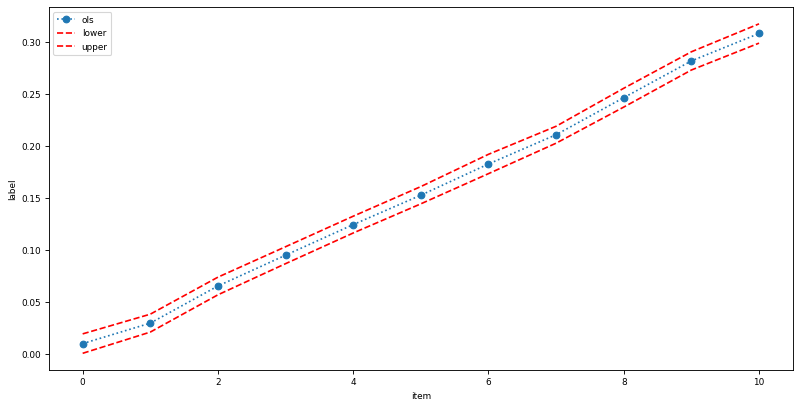

In [16]:
pred_ols = model._results.get_prediction()

iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

iv_l,iv_u

# ---------------------------

plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

w = 12
h = 6

nrows,ncols = 1,1
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[w*ncols,h*nrows],
                    dpi=plt.rcParams["figure.dpi"])

ax.plot(model._results.fittedvalues,"o:",label="ols")
ax.plot(iv_l,"r--",label="lower")
ax.plot(iv_u,"r--",label="upper")


ax.legend()
ax.set_ylabel("label")
ax.set_xlabel("item")

plt.show()
plt.close()

In [17]:
from statsmodels.stats.anova import anova_lm

anova_results = anova_lm(model)
print(anova_results)

           df    sum_sq   mean_sq            F        PR(>F)
L         1.0  0.093477  0.093477  9413.649446  3.255501e-12
a         1.0  0.006784  0.006784   683.157195  3.070276e-08
b         1.0  0.001088  0.001088   109.528626  1.583694e-05
Residual  7.0  0.000070  0.000010          NaN           NaN


### predict with the OLS model
  
predict the given test data with the OLS model and compare  
>the mean squared error (mse) is printed below  
compare to the prediction of the train data

In [18]:
L = test_items["l"].to_numpy(dtype=np.float32)
a = test_items["a"].to_numpy(dtype=np.float32)
b = test_items["b"].to_numpy(dtype=np.float32)
z_test = test_items["label"].to_numpy(dtype=np.float32)

test_data = pd.DataFrame({'L': L, 'a': a, 'b': b, 'z' : z_test})

z_pred = model.predict(test_data).to_numpy()

mse_test = np.mean((z_test-z_pred)**2)

print("mse of test:",mse_test)

test 0.0011207765798804325


In [20]:
# compare for conv.
z_train = model.predict(train_data).to_numpy()
mse_train = np.mean((z-z_train)**2)

print("mse of train",mse_train)

mse of train 6.319075837941838e-06


### memento

train and test data is given by two different NO2 projects  
  
>train data is given with concentrations of z with 0.010 to 0.308 and stored in the OLS model  
test data is given with concentrations of z with 0.035 to 0.151 and predicted by then OLS  

In [22]:
train_data

,L,a,b,z
0,0.430652,0.517578,0.562847,0.010
1,0.413787,0.529351,0.561210,0.034
2,0.378746,0.541572,0.559957,0.061
3,0.361228,0.556480,0.558924,0.095
4,0.345198,0.566267,0.559216,0.121
5,0.326846,0.577057,0.558882,0.155
6,0.334527,0.587767,0.561369,0.181
7,0.306793,0.596199,0.560651,0.213
8,0.285046,0.604229,0.561675,0.249
9,0.297915,0.614686,0.565486,0.281


In [23]:
test_data

,L,a,b,z
0,0.351554,0.529403,0.554066,0.035
1,0.368202,0.531570,0.553719,0.040
2,0.360287,0.532660,0.552420,0.045
3,0.348242,0.541800,0.553428,0.060
4,0.345196,0.540679,0.552162,0.061
5,0.337483,0.543833,0.551637,0.071
6,0.349165,0.547556,0.551148,0.079
7,0.339264,0.552494,0.553381,0.088
8,0.322692,0.559920,0.550649,0.110
9,0.307571,0.560480,0.549631,0.115


### plot the result

how test data fits to prediction  
  
>as expected, the prediction is not good and has potential for improvement  
for a first try out, the tendence is given and accepted  

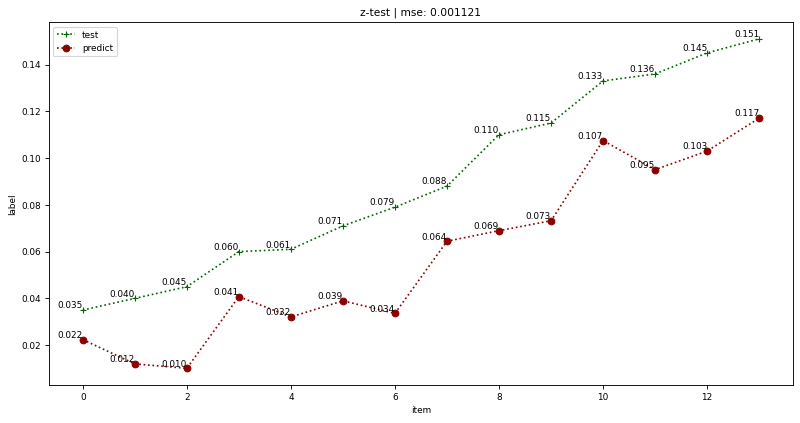

In [30]:
plt.rcParams["font.size"] = 8
plt.rcParams["figure.dpi"] = 80

w = 12
h = 6

nrows,ncols = 1,1
fig, ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=[w*ncols,h*nrows],
                    dpi=plt.rcParams["figure.dpi"])

ax.plot(z_test,"+:",label="test",color="darkgreen")
for i,z_ in enumerate(z_test):
    ax.annotate(f"{z_:.3f}",xy=(i,z_),ha="right",va="bottom")

ax.plot(z_pred,"o:",label="predict",color="darkred")
for i,z_ in enumerate(z_pred):
    ax.annotate(f"{z_:.3f}",xy=(i,z_),ha="right",va="bottom")

ax.set_title(f"z-test | mse: {mse_test:.6f}")

ax.legend()
ax.set_ylabel("label")
ax.set_xlabel("item")

plt.show()
plt.close()

last (manual) update: 2023-08-28